In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from glob import glob
import re

import librosa
import librosa.display
import IPython.display as ipd

In [81]:
TOP_DB = 40
MFCC_SIZE = 39

## Read file

In [3]:
audio_files = sorted(glob('./recordings/*'))

In [4]:
import re

text = audio_files[300]
pattern = r'(\d+)_([a-zA-Z]+)_(\d+)\.wav'

result = re.search(pattern, text)
groups = result.groups()
dictionary = {
    'number': int(groups[0]),
    'name': groups[1],
    'order': int(groups[2])
}
dictionary

{'number': 1, 'name': 'george', 'order': 0}

In [5]:
def convert_path_to_dict(path):
    pattern = r'(\d+)_([a-zA-Z]+)_(\d+)\.wav'

    result = re.search(pattern, path)
    groups = result.groups()
    return {
        'number': int(groups[0]),
        'name': groups[1],
        'order': int(groups[2])
    }
convert_path_to_dict(audio_files[300])

{'number': 1, 'name': 'george', 'order': 0}

## MFCC

In [211]:
def analyse_audio(path):
    output = convert_path_to_dict(path)
    y, sr = librosa.load(path)
    y_tr, index = librosa.effects.trim(y, top_db=TOP_DB)
    mfcc = np.array(librosa.feature.mfcc(y=y_tr, sr=sr, n_mfcc=13))
    output['sr'] = sr
    output['y'] = y
    output['y trim'] = y_tr
    output['mfcc'] = mfcc.T
    return output
print([len(i) for i in analyse_audio(audio_files[0])['mfcc']])
print([len(i) for i in analyse_audio(audio_files[1])['mfcc']])
print([len(i) for i in analyse_audio(audio_files[2])['mfcc']])

[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]
[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]
[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]


In [212]:
output_list = [analyse_audio(file) for file in audio_files]
df = pd.DataFrame(output_list)
df[:3]

,number,name,order,sr,y,y trim,mfcc
0,0,george,0,22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-633.7214, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,0,george,1,22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-643.057, 25.02723, 23.553139, 21.222677, 18..."
2,0,george,10,22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-638.5822, -0.03040633, -19.927683, -0.31883..."


Text(0.5, 1.0, 'MFCC')

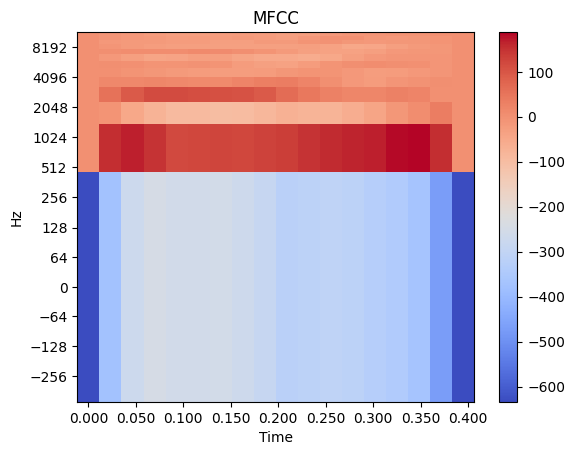

In [214]:
img = librosa.display.specshow(df['mfcc'][0].T, x_axis='time', y_axis="log")
plt.colorbar(img)
plt.title('MFCC')

In [190]:
df[df['number'] == 1]['name'].iloc[0]

'george'

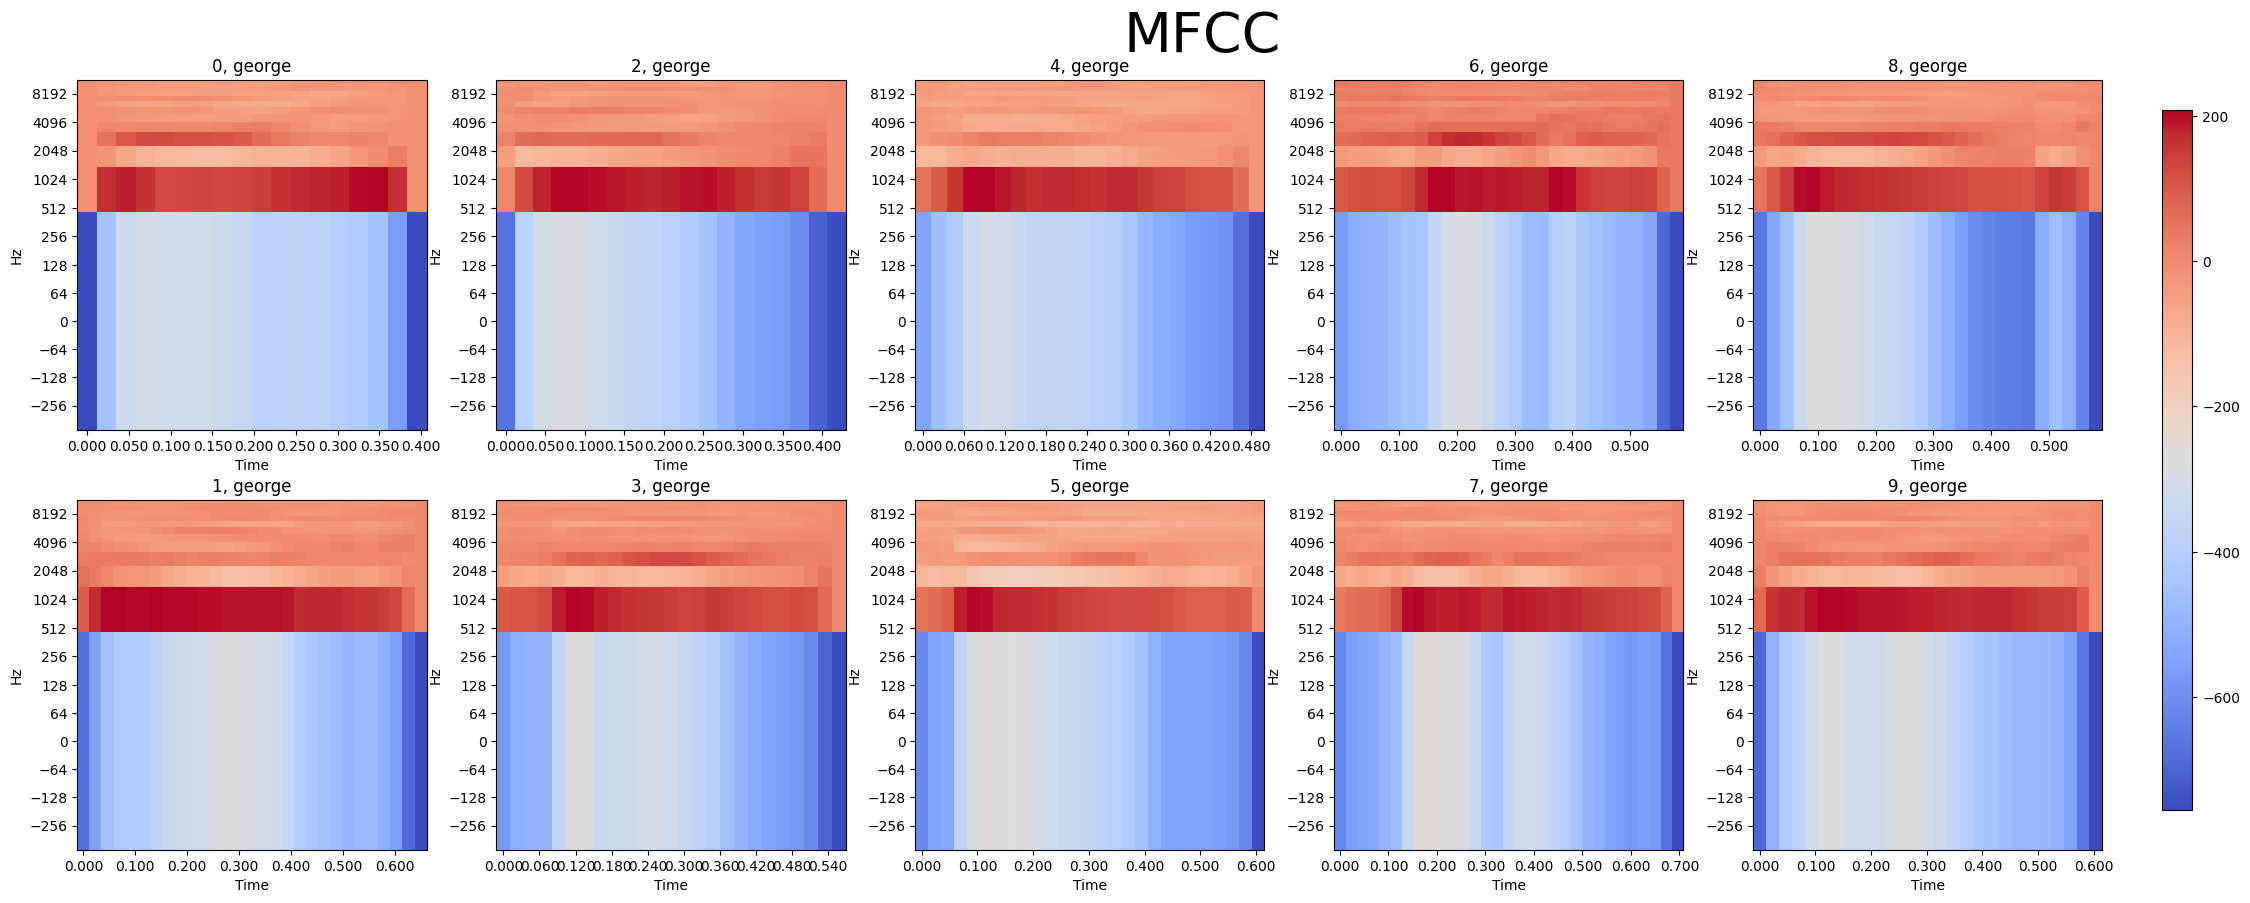

In [215]:
fig, axs = plt.subplots(2, 5, figsize=(30,10))
img=None
for i in range(10):
    img = librosa.display.specshow(df[df['number'] == i]['mfcc'].iloc[0].T, x_axis='time', y_axis="log",ax=axs[i%2,i//2])
    axs[i%2,i//2].set_title(f"{i}, {df[df['number'] == i]['name'].iloc[0]}")
fig.suptitle('MFCC',y=0.95,fontsize=40)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.7])
fig.colorbar(img, cax=cbar_ax)

In [284]:
from hmmlearn import hmm

my_hmm = dict()
for i in df['number'].unique():
    hmm_train = hmm.GaussianHMM(n_components=10, covariance_type='diag', n_iter=1000)
    data_len = [len(i) for i in df[df['number'] == i][:-30]['mfcc']]
    data = np.concatenate(np.array(df[df['number'] == i][:-30]['mfcc']))
    hmm_train.fit(data, lengths=data_len)
    my_hmm[i] = hmm_train


In [297]:
my_hmm = dict()
for num in df['number'].unique():
    data_len = []
    data = []
    for name in df['name'].unique():
        data_len = [len(i) for i in df[df['number'] == num][:-30]['mfcc']]
        data = np.concatenate(np.array(df[df['number'] == num][:-30]['mfcc']))
    hmm_train = hmm.GaussianHMM(n_components=10, covariance_type='diag', n_iter=1000)
    hmm_train.fit(data, lengths=data_len)
    my_hmm[num] = hmm_train


,number,name,order,sr,y,y trim,mfcc
300,1,george,0,22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-9.313226e-10, 2.7939677e-09, -1.8626451e-09,...","[[-667.39307, 92.94522, 53.59893, 29.240776, 1..."
320,1,george,27,22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.7939677e-09, -6.0535967e-09, -7.916242e-09,...","[[-620.55695, 73.214294, 46.601505, 27.65104, ..."


In [285]:
result = dict()
for i in df['number'].unique():
    result[i] = []
    for j in df[df['number'] == i][-30:]['mfcc']:
        tmp = dict()
        for k in df['number'].unique():
            tmp[k] = my_hmm[k].score(j)
        q = max(tmp, key=lambda k: tmp[k])
        result[i].append(q)
a = pd.DataFrame(result)

In [294]:
c = {}
for i in df['number'].unique():
    c[i] = (30 - len(a[a[i] != i]))/30
pd.Series(c)

0    1.000000
1    1.000000
2    0.766667
3    0.900000
4    1.000000
5    0.933333
6    0.466667
7    1.000000
8    1.000000
9    1.000000
dtype: float64